# Enron Emails

This dataset contains approximately 50,000 emails from enron executives. Information and the dataset can be found [here](https://www.cs.cmu.edu/~enron/).

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [13]:
data = pd.read_csv('emails.csv.zip')

In [14]:
data.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [15]:
print(data['message'][1])

Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>
Date: Fri, 4 May 2001 13:51:00 -0700 (PDT)
From: phillip.allen@enron.com
To: john.lavorato@enron.com
Subject: Re:
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.

As far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the

__So, the emails are arranged in one big string. We'll have to parse out this data to use it.__

__We'll find the to and from emails, the sender and receiver, the subject line (if any), and the body of the email.__

In [16]:
#these are going to be the lists we append to, that will become the columns of our dataframe
from_email = []
to_email = []
subject_text = []
sender = []
receiver = []
message = []

#parse out the different parts of the message to become parts of our dataframe
for i in range(len(data.message)):
    #indexes
    first_from = data['message'][i].find('From:') + 6
    first_to = data['message'][i].find('To:')
    subject = data['message'][i].find('Subject:')
    mime = data['message'][i].find('Mime-')
    
    #the actual values
    from_email.append(data['message'][i][first_from : first_to].strip())
    to_email.append(data['message'][i][first_to + 3 : subject].strip())
    subject_text.append(data['message'][i][subject + 8 : mime].strip())
    
    #second batch of indexes to help us find the second from and to
    second_from = data['message'][i].find('From:', first_from) + 6
    second_to = data['message'][i].find('X-To:', subject)
    cc = data['message'][i].find('X-cc')
    
    #senders and receivers
    sender.append(data['message'][i][second_from : second_to].strip())
    receiver.append(data['message'][i][second_to + 5 : cc].strip())
    
    #now find the messages
    filename = data.message[i].find('X-FileName')
    space = data.message[i].find('\n', filename)
    message.append(data.message[i][space:])

In [17]:
#create our new df and append the values
big_df = pd.DataFrame()

big_df['from_email'] = from_email
big_df['to_email'] = to_email
big_df['subject'] = subject_text
big_df['sender'] = sender
big_df['receiver'] = receiver
big_df['message'] =  message

__Let's make its own csv, so we don't have to run the code again.__

In [18]:
big_df.to_csv('parsed_emails.csv', index=False)

# Parsed Dataframe

Now that we have our original messages parsed into different groups. Let's do some light exploration to decide how best to clean and eventually split our data.

In [19]:
large_df = pd.read_csv('parsed_emails.csv')

In [20]:
large_df.head()

,from_email,to_email,subject,sender,receiver,message
0,phillip.allen@enron.com,tim.belden@enron.com,NaN,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,\n\nHere is our forecast\n\n
1,phillip.allen@enron.com,john.lavorato@enron.com,Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,\n\nTraveling to have a business meeting takes...
2,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,Phillip K Allen,Leah Van Arsdall,\n\ntest successful. way to go!!!
3,phillip.allen@enron.com,randall.gay@enron.com,NaN,Phillip K Allen,Randall L Gay,"\n\nRandy,\n\n Can you send me a schedule of t..."
4,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Phillip K Allen,Greg Piper,\n\nLet's shoot for Tuesday at 11:45.


__Ok, now that we've combined our df, let's remove some characters.__

In [21]:
characters = ['\n', '\t', "'", '""', "*", ",", "=", "@", "-", '2001', '2000', 'hou', 'com', 'pmto', 'subject', 'forwarded', '01', 'pm', '04', '03', '11', '02', '10', '12', '09', '05', '08', '07']

#remove some characters from our text
for character in characters:
    large_df.message = large_df.message.apply(lambda x: str(x).replace(character, ''))

    #make our text lowercase
large_df.message = large_df.message.apply(lambda x: str(x).lower())

In [22]:
#new feature -> length of message!
large_df['message_length'] = large_df['message'].apply(lambda x: len(x))

__We only need ten authors, but which one's to choose? Let's go with the ten who have the most emails. We'll check to see what they're average email length is after that to confirm.__

In [23]:
top_ten = large_df.groupby('from_email').count().sort_values(by='to_email', ascending=False).index[:10].tolist()

In [24]:
top_ten

['kay.mann@enron.com',
 'vince.kaminski@enron.com',
 'jeff.dasovich@enron.com',
 'pete.davis@enron.com',
 'sara.shackleton@enron.com',
 'chris.germany@enron.com',
 'enron.announcements@enron.com',
 'tana.jones@enron.com',
 'steven.kean@enron.com',
 'kate.symes@enron.com']

__Ok, here are our top ten. Let's make a new dataframe of just these.__

In [25]:
#first email address
combined_df = large_df.loc[large_df['from_email'] == top_ten[0]]

for i in range(1, len(top_ten)):
    #next email address in range
    temp_df = large_df.loc[large_df['from_email'] == top_ten[i]]
    #add the temp df to our old one
    combined_df = combined_df.append(temp_df, ignore_index=True)

In [26]:
combined_df.shape

(97767, 7)

In [27]:
#let's see what they're average message length is.
combined_df.groupby('from_email')['message_length'].mean()

from_email
chris.germany@enron.com           854.127044
enron.announcements@enron.com    2038.479888
jeff.dasovich@enron.com          1992.913937
kate.symes@enron.com              736.704692
kay.mann@enron.com               1126.075713
pete.davis@enron.com              693.312602
sara.shackleton@enron.com        1178.443759
steven.kean@enron.com            2402.836334
tana.jones@enron.com              958.467622
vince.kaminski@enron.com         1433.859725
Name: message_length, dtype: float64

__These are all pretty decent lengths! Now we need to break apart every message into its unique sentences.__

In [28]:
#replace questions and exclamations with periods to use for splitting
combined_df['message'] = combined_df['message'].apply(lambda x: x.replace('?', '.'))
combined_df['message'] = combined_df['message'].apply(lambda x: x.replace('!', '.'))

In [29]:
#create a list of each individual sentence and each individual sender_email
sender_email = []
sentences = []

for name in top_ten:
    #loop through each author
    temp_df = combined_df.loc[combined_df['from_email'] == name]
    #parse each message into unique sentences and add them to the list
    for message in temp_df.message:
        sentence_split = message.split('.')
        for sentence in sentence_split:
            sentences.append(sentence)
            sender_email.append(name)

In [30]:
#our new df!
df = pd.DataFrame()
df['author'] = sender_email
df['sentence'] = sentences

In [31]:
df.head(2)

,author,sentence
0,kay.mann@enron.com,we are in a loop
1,kay.mann@enron.com,we need a process to deal with this


__Ok! Our new df of each sentence is created. Let's dig deeper into these messages.__

In [32]:
df['message_length'] = df['sentence'].apply(lambda x: len(x))

df['message_length'].describe()

count    1.969291e+06
mean     6.543401e+01
std      1.033050e+02
min      0.000000e+00
25%      1.000000e+01
50%      3.800000e+01
75%      9.000000e+01
max      1.026700e+04
Name: message_length, dtype: float64

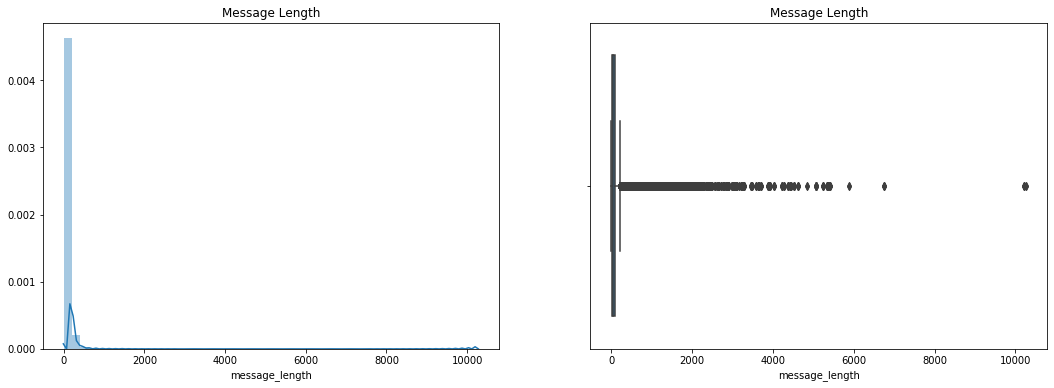

In [33]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.distplot(df.message_length)
plt.title('Message Length')

plt.subplot(1, 2, 2)
sns.boxplot(df.message_length)
plt.title('Message Length')

plt.show()

__Wow! We have a lot of outliers for our message length. Let's clean that up some.__

In [34]:
df.groupby('author')['message_length'].mean()

author
chris.germany@enron.com          54.711819
enron.announcements@enron.com    83.354627
jeff.dasovich@enron.com          62.803229
kate.symes@enron.com             66.175301
kay.mann@enron.com               62.258245
pete.davis@enron.com             39.016039
sara.shackleton@enron.com        64.473562
steven.kean@enron.com            86.145775
tana.jones@enron.com             86.522927
vince.kaminski@enron.com         60.636923
Name: message_length, dtype: float64

In [35]:
df['message_length'].describe()

count    1.969291e+06
mean     6.543401e+01
std      1.033050e+02
min      0.000000e+00
25%      1.000000e+01
50%      3.800000e+01
75%      9.000000e+01
max      1.026700e+04
Name: message_length, dtype: float64

In [36]:
#Only include messages greater than 10 and less than 200
df = df.loc[(df.message_length >= 55) & (df.message_length < 200)]

In [37]:
#let's review the results again
df.message_length.describe()

count    682065.000000
mean        105.638750
std          37.885533
min          55.000000
25%          74.000000
50%          97.000000
75%         132.000000
max         199.000000
Name: message_length, dtype: float64

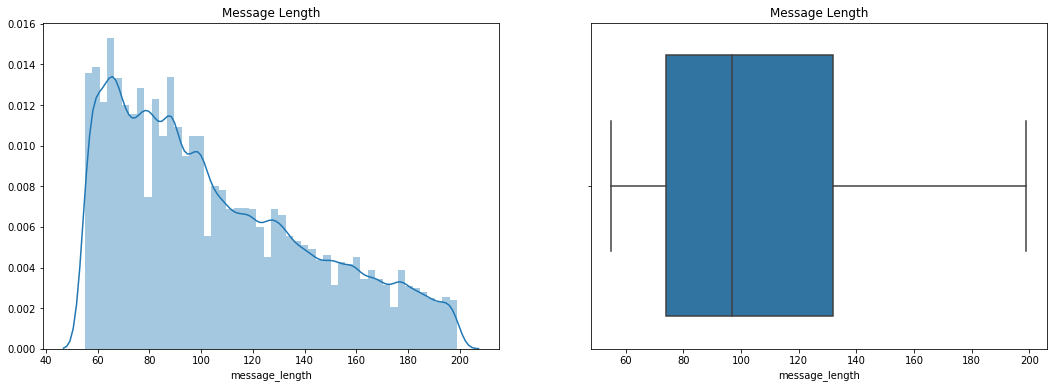

In [38]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.distplot(df.message_length)
plt.title('Message Length')

plt.subplot(1, 2, 2)
sns.boxplot(df.message_length)
plt.title('Message Length')

plt.show()

In [39]:
df.shape

(682065, 3)

__This is still a huge data set, especially considering the computational limitations I use. Let's only use a certain percent of it of our dataframe.__

In [40]:
from sklearn.model_selection import train_test_split

#split our features and targets
features = df[['sentence', 'message_length']]
target = df['author']

#only use 15% of our dataset
feature_tossed, features, target_tossed, target = train_test_split(features, target, test_size=0.15, random_state=42)

In [41]:
features.shape

(102310, 2)

__How does our split of author representation compare with our original dataframe?__

In [42]:
test = pd.concat([features, target], axis=1)

test.author.value_counts() / len(test) * 100

vince.kaminski@enron.com         16.183169
jeff.dasovich@enron.com          15.862575
kay.mann@enron.com               14.597791
enron.announcements@enron.com    14.382758
steven.kean@enron.com            10.451569
sara.shackleton@enron.com         7.832079
pete.davis@enron.com              6.393314
chris.germany@enron.com           5.849868
tana.jones@enron.com              4.966279
kate.symes@enron.com              3.480598
Name: author, dtype: float64

In [43]:
df['author'].value_counts() / len(df) * 100

vince.kaminski@enron.com         16.135266
jeff.dasovich@enron.com          15.770344
kay.mann@enron.com               14.624266
enron.announcements@enron.com    14.431029
steven.kean@enron.com            10.432583
sara.shackleton@enron.com         7.876669
pete.davis@enron.com              6.341624
chris.germany@enron.com           5.915419
tana.jones@enron.com              5.016824
kate.symes@enron.com              3.455976
Name: author, dtype: float64

__Ok, our split seems to mimic the same balance as our original df.__

__It's time to vectorize our data and start our unsupervised learning!__

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=1000)

vector = vectorizer.fit_transform(features['sentence'])

In [45]:
#set up our X and y values
columns = vectorizer.get_feature_names()
length = features['message_length'].tolist()

X = pd.DataFrame(vector.toarray(), columns=columns)
X['message_length'] = length
y = target

In [46]:
X.shape

(102310, 1001)

__Ok, now that our data is vectorized. Let's create our holdout group and then begin our unsupervised learning!__

In [47]:
#setup our holdout group
from sklearn.model_selection import train_test_split

X, X_holdout, y, y_holdout = train_test_split(X, y, test_size=0.25, random_state=42)

__Let's do some clustering. First, we'll see what the most appropriate clustering is.__

__Silhouette Coefficient__

In [48]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

for i in range(1, 11):
    try:
        model = KMeans(n_clusters=i, random_state=42).fit(X.drop(columns='message_length'))
        labels = model.labels_
        print('Number of clusters: {}'.format(i))
        print(metrics.silhouette_score(X.drop(columns='message_length'), labels, metric='euclidean'))
        print('')
    except:
        print('{} Clusters is no good'.format(i))
        print('')

Number of clusters: 1
1 Clusters is no good

Number of clusters: 2
0.2043139127813466

Number of clusters: 3
0.20535603805413127

Number of clusters: 4
0.20750991382214778

Number of clusters: 5
0.11777055704959646

Number of clusters: 6
0.1300855698864332

Number of clusters: 7
0.12877797913171649

Number of clusters: 8
0.13789618947764898

Number of clusters: 9
0.038888922776279505

Number of clusters: 10
0.06293760046285297



__Mean Shift__

In [49]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 1


__According to our Silhouette score, the best are 2, 3, and 4 clusters. Mean shift does one cluster, but that doesn't really help us.__

__Let's do some exploration of each one!__

2 groups

In [50]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42)

kmeans.fit(X.drop(columns='message_length'))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [51]:
X['labels'] = kmeans.labels_

X.labels.value_counts()

1    75683
0     1049
Name: labels, dtype: int64

In [52]:
X['author'] = y.tolist()

In [53]:
X.groupby('labels')['message_length'].mean()

labels
0     97.067684
1    105.807526
Name: message_length, dtype: float64

__Which authors are in which groups?__

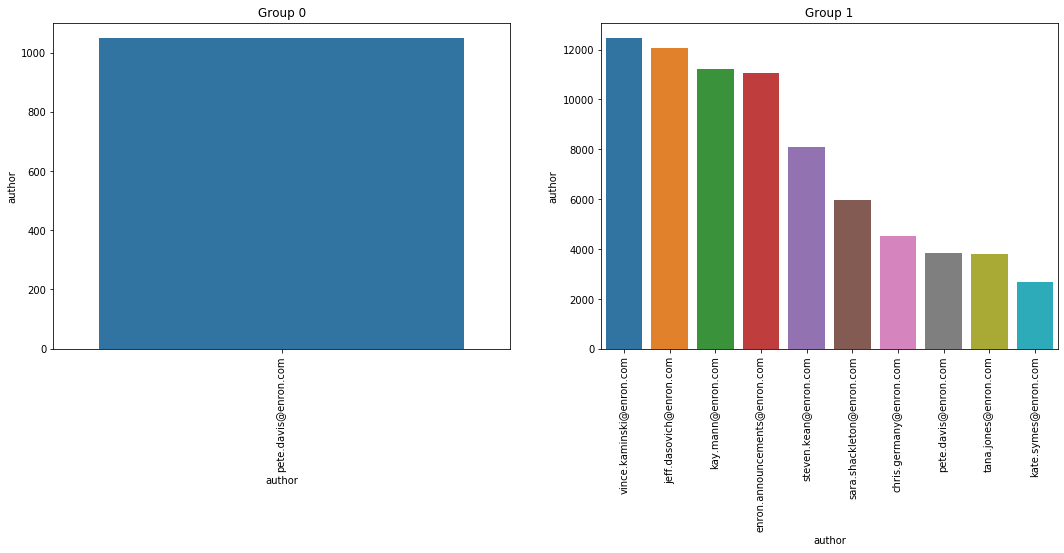

In [54]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.barplot(X.groupby('labels')['author'].value_counts()[0].index, X.groupby('labels')['author'].value_counts()[0])
plt.title('Group 0')
plt.xticks(rotation='vertical')

plt.subplot(1, 2, 2)
sns.barplot(X.groupby('labels')['author'].value_counts()[1].index, X.groupby('labels')['author'].value_counts()[1])
plt.title('Group 1')
plt.xticks(rotation='vertical')

plt.show()

In [55]:
X.groupby('author').mean().loc['pete.davis@enron.com', :].sort_values(ascending=False)[1:10]

labels       0.786180
final        0.465349
error        0.440277
schedules    0.392581
database     0.296779
hourahead    0.268854
iso          0.258459
schedule     0.235426
start        0.219323
Name: pete.davis@enron.com, dtype: float64

In [56]:
most_important = pd.DataFrame()

most_important['columns'] = X.groupby('labels').mean().columns.tolist()
most_important['values'] = X.groupby('labels').mean().loc[0, :].tolist()

In [57]:
most_important.sort_values(by='values', ascending=False)[1 : 20]

,columns,values
358,file,1.000000
685,portland,1.000000
360,final,1.000000
153,california,1.000000
978,westdesk,1.000000
794,scheduling,1.000000
793,schedules,1.000000
461,iso,1.000000
520,log,0.904671
566,messages,0.904671


In [58]:
most_important = pd.DataFrame()

most_important['columns'] = X.groupby('labels').mean().columns.tolist()
most_important['values'] = X.groupby('labels').mean().loc[1, :].tolist()

In [59]:
most_important.sort_values(by='values', ascending=False)[1 : 20]

,columns,values
313,enron,0.080745
863,subject,0.063409
420,hou,0.043286
690,power,0.036521
309,energy,0.033825
372,forwarded,0.032636
326,error,0.031381
487,know,0.030179
304,email,0.029465
208,corp,0.028527


So, it looks like it split one group entirely of one author, and all the rest in the other.

It seems like he might be in some sort of IT position based on the words he was using.

3 groups

In [60]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)

kmeans.fit(X.drop(columns=['message_length', 'author', 'labels']))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [61]:
X['labels_3'] = kmeans.labels_

X.labels_3.value_counts()

1    71429
2     4254
0     1049
Name: labels_3, dtype: int64

In [62]:
X.groupby('labels_3')['message_length'].mean()

labels_3
0     97.067684
1    104.942040
2    120.339915
Name: message_length, dtype: float64

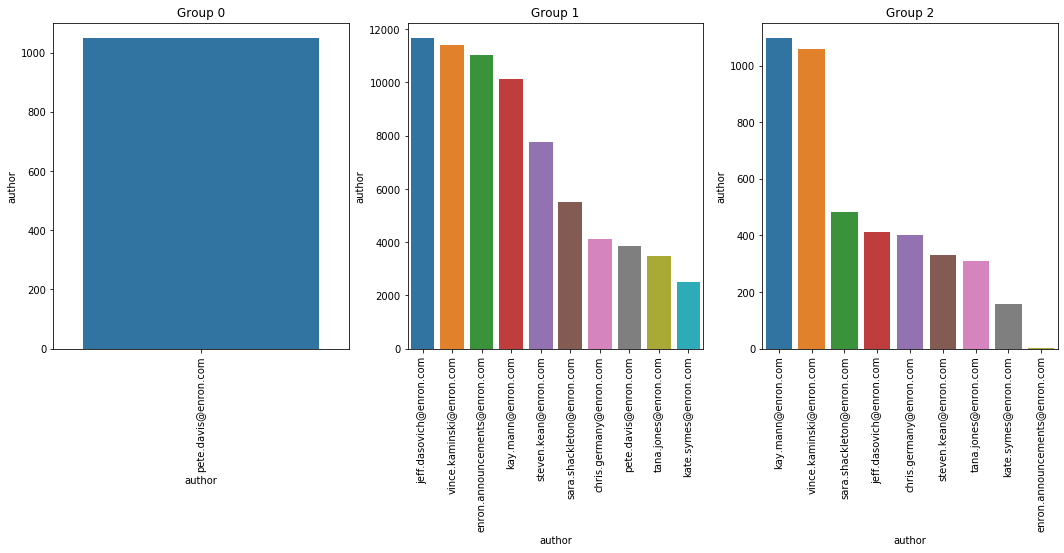

In [63]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(X.groupby('labels_3')['author'].value_counts()[0].index, X.groupby('labels_3')['author'].value_counts()[0])
plt.title('Group 0')
plt.xticks(rotation='vertical')

plt.subplot(1, 3, 2)
sns.barplot(X.groupby('labels_3')['author'].value_counts()[1].index, X.groupby('labels_3')['author'].value_counts()[1])
plt.title('Group 1')
plt.xticks(rotation='vertical')

plt.subplot(1, 3, 3)
sns.barplot(X.groupby('labels_3')['author'].value_counts()[2].index, X.groupby('labels_3')['author'].value_counts()[2])
plt.title('Group 2')
plt.xticks(rotation='vertical')


plt.show()

In [64]:
most_important = pd.DataFrame()

most_important['columns'] = X.groupby('labels_3').mean().columns.tolist()
most_important['values'] = X.groupby('labels_3').mean().loc[0, :].tolist()

In [65]:
most_important.sort_values(by='values', ascending=False)[1 : 20]

,columns,values
153,california,1.000000
461,iso,1.000000
358,file,1.000000
793,schedules,1.000000
794,scheduling,1.000000
978,westdesk,1.000000
685,portland,1.000000
360,final,1.000000
520,log,0.904671
566,messages,0.904671


In [66]:
most_important = pd.DataFrame()

most_important['columns'] = X.groupby('labels_3').mean().columns.tolist()
most_important['values'] = X.groupby('labels_3').mean().loc[1, :].tolist()

In [67]:
most_important.sort_values(by='values', ascending=False)[2 : 20]

,columns,values
313,enron,0.064442
690,power,0.037926
863,subject,0.037576
309,energy,0.034916
326,error,0.033222
487,know,0.031248
304,email,0.030744
596,new,0.029078
444,information,0.027804
781,said,0.027412


In [68]:
most_important = pd.DataFrame()

most_important['columns'] = X.groupby('labels_3').mean().columns.tolist()
most_important['values'] = X.groupby('labels_3').mean().loc[2, :].tolist()

In [69]:
most_important.sort_values(by='values', ascending=False)[2 : 20]

,columns,values
420,hou,0.763282
372,forwarded,0.563940
863,subject,0.497179
677,pm,0.415609
208,corp,0.362012
313,enron,0.354490
290,ect,0.338035
958,vince,0.311942
482,kay,0.304184
291,ectect,0.272685


__4 groups__

In [70]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)

kmeans.fit(X.drop(columns=['message_length', 'author', 'labels', 'labels_3']))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [71]:
X['labels_4'] = kmeans.labels_

X.labels_4.value_counts()

0    71434
2     2474
1     1775
3     1049
Name: labels_4, dtype: int64

In [72]:
X.groupby('labels_4')['message_length'].mean()

labels_4
0    104.953790
1    118.636056
2    121.254244
3     97.067684
Name: message_length, dtype: float64

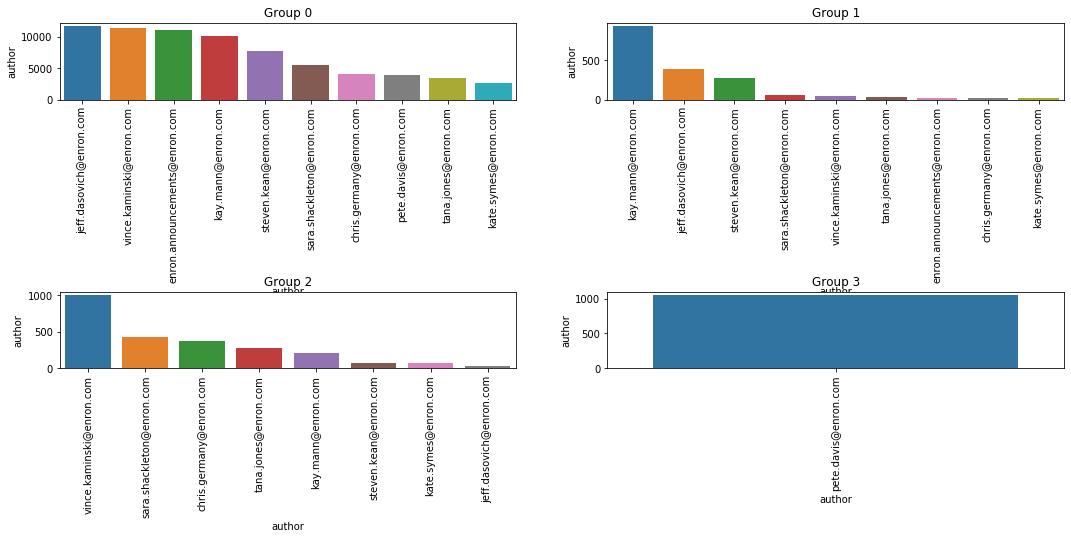

In [73]:
plt.figure(figsize=(18, 6))
plt.subplots_adjust(left=None, right=None, bottom=0.1, top=0.9, hspace=2.5)

plt.subplot(2, 2, 1)
sns.barplot(X.groupby('labels_4')['author'].value_counts()[0].index, X.groupby('labels_4')['author'].value_counts()[0])
plt.title('Group 0')
plt.xticks(rotation='vertical')

plt.subplot(2, 2, 2)
sns.barplot(X.groupby('labels_4')['author'].value_counts()[1].index, X.groupby('labels_4')['author'].value_counts()[1])
plt.title('Group 1')
plt.xticks(rotation='vertical')

plt.subplot(2, 2, 3)
sns.barplot(X.groupby('labels_4')['author'].value_counts()[2].index, X.groupby('labels_4')['author'].value_counts()[2])
plt.title('Group 2')
plt.xticks(rotation='vertical')

plt.subplot(2, 2, 4)
sns.barplot(X.groupby('labels_4')['author'].value_counts()[3].index, X.groupby('labels_4')['author'].value_counts()[3])
plt.title('Group 3')
plt.xticks(rotation='vertical')

plt.show()

In [74]:
most_important = pd.DataFrame()

most_important['columns'] = X.groupby('labels_4').mean().columns.tolist()
most_important['values'] = X.groupby('labels_4').mean().loc[0, :].tolist()

In [75]:
most_important.sort_values(by='values', ascending=False)[3 : 20]

,columns,values
313,enron,0.062183
863,subject,0.038357
690,power,0.037937
309,energy,0.034913
326,error,0.033219
487,know,0.031176
304,email,0.030728
596,new,0.028950
444,information,0.027802
781,said,0.027382


In [76]:
most_important = pd.DataFrame()

most_important['columns'] = X.groupby('labels_4').mean().columns.tolist()
most_important['values'] = X.groupby('labels_4').mean().loc[1, :].tolist()

In [77]:
most_important.sort_values(by='values', ascending=False)[3 : 20]

,columns,values
313,enron,0.798873
208,corp,0.721690
482,kay,0.683380
372,forwarded,0.602817
542,mann,0.574648
583,na,0.487324
677,pm,0.439437
863,subject,0.411268
314,enronenron,0.267042
469,jeff,0.266479


In [78]:
most_important = pd.DataFrame()

most_important['columns'] = X.groupby('labels_4').mean().columns.tolist()
most_important['values'] = X.groupby('labels_4').mean().loc[2, :].tolist()

In [79]:
most_important.sort_values(by='values', ascending=False)[3 : 20]

,columns,values
1001,labels,1.000000
863,subject,0.537187
290,ect,0.531932
372,forwarded,0.530315
958,vince,0.525869
479,kaminski,0.431690
291,ectect,0.417138
677,pm,0.382781
292,ectectcc,0.315683
785,sara,0.219483


In [80]:
most_important = pd.DataFrame()

most_important['columns'] = X.groupby('labels_4').mean().columns.tolist()
most_important['values'] = X.groupby('labels_4').mean().loc[3, :].tolist()

In [81]:
most_important.sort_values(by='values', ascending=False)[3 : 20]

,columns,values
685,portland,1.000000
978,westdesk,1.000000
794,scheduling,1.000000
793,schedules,1.000000
358,file,1.000000
461,iso,1.000000
566,messages,0.904671
520,log,0.904671
641,parsing,0.895138
326,error,0.104862


__Ok, now let's try to build models that will predict the author!__

__MLP__

In [82]:
X = X.drop(columns=['message_length', 'labels', 'author', 'labels_3', 'labels_4'])

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [84]:
ranges = [0.0001, 0.001, 0.01, 0.1]

In [85]:
from sklearn.neural_network import MLPClassifier

#NOTE: This was previously tuned with GridSearch
mlp = MLPClassifier(activation='relu', solver='lbfgs', alpha=0.1)
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [86]:
print('The r^2 of our training data is {}'.format(round(mlp.score(X_train, y_train), 4)))
print('The r^2 of our test data is {}'.format(round(mlp.score(X_test, y_test), 4)))

The r^2 of our training data is 0.8838
The r^2 of our test data is 0.6382


__Random Forest Regressor__

In [87]:
from sklearn.ensemble import RandomForestClassifier

#NOTE: This was tuned with GridSearch
rfc = RandomForestClassifier(max_features='sqrt', n_estimators=285)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=285,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [88]:
print('The r^2 of our test data is {}'.format(round(rfc.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(rfc.score(X_train, y_train), 4)))

The r^2 of our test data is 0.6688
The r^2 of our training data is 0.9493


__Random Forest w/Neural Network Feature Generation__

In [89]:
from sklearn.neural_network import BernoulliRBM

rbm = BernoulliRBM()
X_N = rbm.fit_transform(X)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_N, y, test_size=0.2)

In [91]:
rbm_rfc = RandomForestClassifier(n_estimators=285, max_features='sqrt')
rbm_rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=285,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [92]:
print('The r^2 of our test data is {}'.format(round(rbm_rfc.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(rbm_rfc.score(X_train, y_train), 4)))

The r^2 of our test data is 0.6745
The r^2 of our training data is 0.9485


## Is the holdout group similar to our training group?

In [93]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

for i in range(1, 11):
    try:
        model = KMeans(n_clusters=i, random_state=42).fit(X_holdout.drop(columns='message_length'))
        labels = model.labels_
        print('Number of clusters: {}'.format(i))
        print(metrics.silhouette_score(X_holdout.drop(columns='message_length'), labels, metric='euclidean'))
        print('')
    except:
        print('{} Clusters is no good'.format(i))
        print('')

Number of clusters: 1
1 Clusters is no good

Number of clusters: 2
0.1423881659468522

Number of clusters: 3
0.2313073494657179

Number of clusters: 4
0.19861182495465526

Number of clusters: 5
0.07048698129090714

Number of clusters: 6
0.2208006047971269

Number of clusters: 7
0.0478667859985438

Number of clusters: 8
0.1109797613177605

Number of clusters: 9
0.0730094123402561

Number of clusters: 10
0.06708341030090641



__Mean Shift__

In [94]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_holdout, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_holdout)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 1


__MLP__

In [95]:
mlp.score(X_holdout.drop(columns='message_length'), y_holdout)

0.6391821096254594

__Random Forest__

In [96]:
rfc.score(X_holdout.drop(columns='message_length'), y_holdout)

0.6787473610133709

__RBM -> RFC__

In [104]:
rbm = BernoulliRBM()
X_N = rbm.fit_transform(X_holdout.drop(columns='message_length'))

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_N, y_holdout, test_size=0.2, random_state=42)

In [107]:
rbm_rfc.fit(X_train, y_train)

print('The R^2 of our training set is {}'.format(rbm_rfc.score(X_train, y_train)))
print('The R^2 of our test set is {}'.format(rbm_rfc.score(X_test, y_test)))

The R^2 of our training set is 0.962809109568957
The R^2 of our test set is 0.5707584050039093


# TDIF Vectorizer

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

vector = vectorizer.fit_transform(features['sentence'])

In [109]:
#set up our X and y values
columns = vectorizer.get_feature_names()
length = features['message_length'].tolist()

X = pd.DataFrame(vector.toarray(), columns=columns)
X['message_length'] = length
y = target

In [110]:
#setup our holdout group
from sklearn.model_selection import train_test_split

X, X_holdout, y, y_holdout = train_test_split(X, y, test_size=0.25, random_state=42)

1. Create a series of clusters

In [111]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

for i in range(1, 11):
    try:
        model = KMeans(n_clusters=i, random_state=42).fit(X.drop(columns='message_length'))
        labels = model.labels_
        print('Number of clusters: {}'.format(i))
        print(metrics.silhouette_score(X.drop(columns='message_length'), labels, metric='euclidean'))
        print('')
    except:
        print('{} Clusters is no good'.format(i))
        print('')

Number of clusters: 1
1 Clusters is no good

Number of clusters: 2
0.017167757118031885

Number of clusters: 3
0.02134351017510026

Number of clusters: 4
0.021688855059722508

Number of clusters: 5
0.03077414924705339

Number of clusters: 6
0.031296996723750733

Number of clusters: 7
0.031194467116451147

Number of clusters: 8
0.030855015647644524

Number of clusters: 9
0.03827123270710004

Number of clusters: 10
0.03955521831746798



In [112]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 1


__Wow, because these silhouette scores are all very poor, we won't use the tdif vectorizer.__

# Increasing stop words using NLTK

In [113]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['enron', 'subject', 'email', 'said', 'enronenron', 'enronenroncc', 'www', 'youre'])

nltk_stop_list = []

for sentence in features.sentence:
    words = word_tokenize(sentence)
    new_list = []
    sentence = ' '
    
    for word in words:
        if word not in stop_words:
            new_list.append(word)
    
    sentence = sentence.join(new_list)
    nltk_stop_list.append(sentence)
    
features['nltk_sentence'] = nltk_stop_list

In [114]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=1000)

vector = vectorizer.fit_transform(features['nltk_sentence'])

In [115]:
#set up our X and y values
columns = vectorizer.get_feature_names()
length = features['message_length'].tolist()

X = pd.DataFrame(vector.toarray(), columns=columns)
X['message_length'] = length
y = target

__Silhouette Coefficient__

In [116]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

for i in range(1, 11):
    try:
        model = KMeans(n_clusters=i, random_state=42).fit(X.drop(columns='message_length'))
        labels = model.labels_
        print('Number of clusters: {}'.format(i))
        print(metrics.silhouette_score(X.drop(columns='message_length'), labels, metric='euclidean'))
        print('')
    except:
        print('{} Clusters is no good'.format(i))
        print('')

Number of clusters: 1
1 Clusters is no good

Number of clusters: 2
0.22529338531300094

Number of clusters: 3
0.22812725109814933

Number of clusters: 4
0.0501191281621165

Number of clusters: 5
0.2204814017494259

Number of clusters: 6
0.12241115592414172

Number of clusters: 7
0.07130853207271166

Number of clusters: 8
0.08114312363309956

Number of clusters: 9
0.21640544225614347

Number of clusters: 10
0.07328572926426419



__Mean Shift__

In [117]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 1


__3 groups__

In [118]:
X['author'] = y.tolist()

In [127]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)

kmeans.fit(X.drop(columns=['message_length', 'author']))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [128]:
X['labels_3'] = kmeans.labels_
X.labels_3.value_counts()

0    94384
2     6634
1     1292
Name: labels_3, dtype: int64

In [129]:
X.groupby('labels_3')['message_length'].mean()

labels_3
0    104.854912
1     97.583591
2    119.013717
Name: message_length, dtype: float64

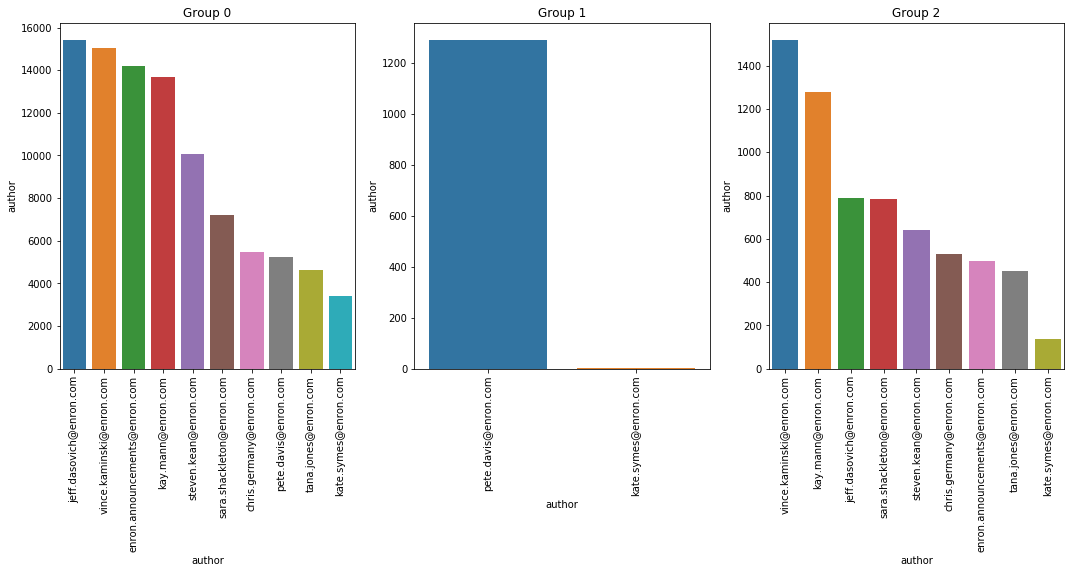

In [131]:
plt.figure(figsize=(18, 6))
plt.subplots_adjust(left=None, right=None, bottom=0.1, top=0.9, hspace=2.5)

plt.subplot(1, 3, 1)
sns.barplot(X.groupby('labels_3')['author'].value_counts()[0].index, X.groupby('labels_3')['author'].value_counts()[0])
plt.title('Group 0')
plt.xticks(rotation='vertical')

plt.subplot(1, 3, 2)
sns.barplot(X.groupby('labels_3')['author'].value_counts()[1].index, X.groupby('labels_3')['author'].value_counts()[1])
plt.title('Group 1')
plt.xticks(rotation='vertical')

plt.subplot(1, 3, 3)
sns.barplot(X.groupby('labels_3')['author'].value_counts()[2].index, X.groupby('labels_3')['author'].value_counts()[2])
plt.title('Group 2')
plt.xticks(rotation='vertical')

plt.show()

In [132]:
most_important = pd.DataFrame()

most_important['columns'] = X.groupby('labels_3').mean().columns.tolist()
most_important['values'] = X.groupby('labels_3').mean().loc[0, :].tolist()

In [133]:
most_important.sort_values(by='values', ascending=False)[3 : 20]

,columns,values
309,energy,0.034889
156,california,0.034508
486,know,0.031022
598,new,0.029168
795,schedules,0.027706
444,information,0.026869
592,need,0.026413
832,sld,0.026191
81,agreement,0.024867
908,time,0.024506


In [135]:
most_important = pd.DataFrame()

most_important['columns'] = X.groupby('labels_3').mean().columns.tolist()
most_important['values'] = X.groupby('labels_3').mean().loc[1, :].tolist()

In [136]:
most_important.sort_values(by='values', ascending=False)[3 : 20]

,columns,values
145,borland,0.999226
113,attempting,0.999226
610,occurred,0.999226
447,initialize,0.999226
310,engine,0.999226
22,2a,0.999226
623,operation,0.129257
660,perform,0.129257
191,closed,0.129257
245,dbcaps97data,0.129257


In [137]:
most_important = pd.DataFrame()

most_important['columns'] = X.groupby('labels_3').mean().columns.tolist()
most_important['values'] = X.groupby('labels_3').mean().loc[2, :].tolist()

In [138]:
most_important.sort_values(by='values', ascending=False)[3 : 20]

,columns,values
679,pm,0.345493
291,ect,0.280072
959,vince,0.252789
211,corp,0.246307
292,ectect,0.221435
313,enron,0.217214
481,kay,0.214501
478,kaminski,0.207416
585,na,0.157673
543,mann,0.156768


__MLP__

In [140]:
X = X.drop(columns=['message_length', 'labels_3', 'author'])

In [141]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [142]:
ranges = [0.0001, 0.001, 0.01, 0.1, 1.0]

In [143]:
from sklearn.neural_network import MLPClassifier

#NOTE: This was already trained using GridSearchCV
mlp = MLPClassifier(solver='lbfgs', activation='relu', alpha=0.001)
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [144]:
print('The r^2 of our training data is {}'.format(round(mlp.score(X_train, y_train), 4)))
print('The r^2 of our test data is {}'.format(round(mlp.score(X_test, y_test), 4)))

The r^2 of our training data is 0.8077
The r^2 of our test data is 0.6434


### Increasing stop words with NLTK, overall assessment

It looks like increasing the stop words increased our silhouette score for higher number of clusters (ie 6 clusters), albeit still very low.

It didn't improve the efficacy of our MLP model.